# Time-varying depths


Some hydrodynamic models (such as SWASH) have time-evolving depth dimensions, for example because they follow the waves on the free surface. Parcels can work with these types of models, but it is a bit involved to set up. That is why we explain here how to run Parcels on `FieldSets` with time-evolving depth dimensions


In [1]:
from datetime import timedelta as delta
from os import path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleFile,
    ParticleSet,
    download_example_dataset,
)

Here, we use sample data from the SWASH model. We first set the `filenames` and `variables`


In [2]:
example_dataset_folder = download_example_dataset("SWASH_data")
filenames = f"{example_dataset_folder}/field_*.nc"
variables = {
    "U": "cross-shore velocity",
    "V": "along-shore velocity",
    "depth_u": "time varying depth_u",
}

Now, the first key step when reading time-evolving depth dimensions is that we specify `depth` as `'not_yet_set'` in the `dimensions` dictionary


In [3]:
dimensions = {
    "U": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
    "V": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
    "depth_u": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
}

Then, _after_ we create the `FieldSet` object, we set the `depth` dimension of the relevant `Fields` to `fieldset.depth_u` and `fieldset.depth_w`, using the `Field.set_depth_from_field()` method


In [4]:
fieldset = FieldSet.from_netcdf(
    filenames, variables, dimensions, mesh="flat", allow_time_extrapolation=True
)
fieldset.U.set_depth_from_field(fieldset.depth_u)
fieldset.V.set_depth_from_field(fieldset.depth_u)

Now, we can create a ParticleSet, run those and plot them


In [5]:
pset = ParticleSet(fieldset, JITParticle, lon=9.5, lat=12.5, depth=-0.1)

pfile = pset.ParticleFile("SwashParticles", outputdt=delta(seconds=0.05))

pset.execute(AdvectionRK4, dt=delta(seconds=0.005), output_file=pfile)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/x0/1qxj679n55zcybylvdsb4bxh0000gq/T/parcels-503/7c3e590563f4ce6e8ed9b2da9eab579a_0.c


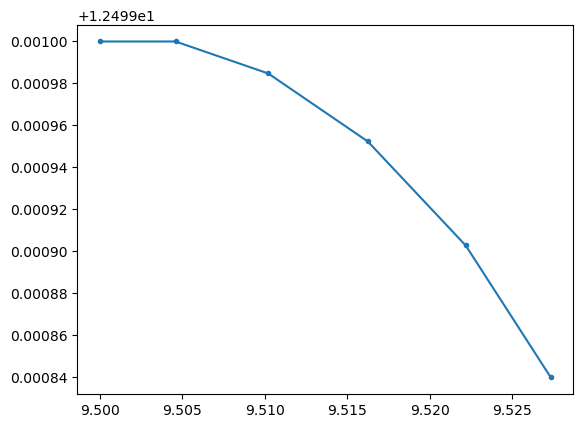

In [6]:
ds = xr.open_zarr("SwashParticles.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.show()

Note that, even though we use 2-dimensional `AdvectionRK4`, the particle still moves down, because the grid itself moves down
